In [1]:
from google.colab import drive

# Mount Google Drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Preparation and Augmentation


In [ ]:
excel_file_path = '/content/drive/MyDrive/Wine_Data/wine_data_1.xlsx'

try:
    df = pd.read_excel(excel_file_path)

    df_cleaned = df.dropna(subset=['image_path'])
    df_cleaned = df_cleaned[df_cleaned['image_path'].str.strip() != '']


    df_cleaned.to_excel(excel_file_path, index=False)

    print(f"Successfully read, cleaned, and saved the data to {excel_file_path}")
    print(f"Original number of rows: {len(df)}")
    print(f"Number of rows after removing null image paths: {len(df_cleaned)}")

except FileNotFoundError:
    print(f"Error: The file was not found at {excel_file_path}")
except KeyError:
    print("Error: 'image_path' column not found in the Excel file.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully read, cleaned, and saved the data to /content/drive/MyDrive/Wine_Data/wine_data_1.xlsx
Original number of rows: 4908
Number of rows after removing null image paths: 4908


In [2]:
class WineDataset(Dataset):
    def __init__(self, root_dir, transform=None, csv_file=None):
        self.root_dir = root_dir
        self.transform = transform

        if csv_file:
            self.df = pd.read_excel(csv_file)
            self.image_paths = self.df['image_path'].values
            self.labels = self.df['Type'].values

            self.class_to_idx = {'Red': 0, 'White': 1, 'Rose': 2, 'Specialty': 3, 'Sparkling': 4, 'Sake_Rice_wine' : 5, 'Icewine': 6, 'Fortified': 7, 'Dessert': 8, 'Champagne': 9}
            self.idx_to_class = {0: 'Red', 1: 'White', 2: 'Rose', 3: 'Specialty', 4: 'Sparkling', 5: 'Sake_Rice_wine', 6: 'Icewine', 7: 'Fortified', 8: 'Dessert', 9: 'Champagne'}
            self.classes = list(self.class_to_idx.keys())

        else:
            self.dataset = ImageFolder(root_dir)
            self.image_paths = [s[0] for s in self.dataset.samples]
            self.labels = [s[1] for s in self.dataset.samples]
            self.classes = self.dataset.classes
            self.class_to_idx = self.dataset.class_to_idx


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if hasattr(self, 'df'):
            img_path = self.image_paths[idx]
        else:
            img_path = os.path.join(self.root_dir, self.image_paths[idx])

        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[self.labels[idx]]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
def get_transforms(augment=False):
    base_transforms = [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ]

    if augment:
        augmentations = [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.RandomPerspective(distortion_scale=0.1, p=0.3)
        ]
        return transforms.Compose(augmentations + base_transforms)
    else:
        return transforms.Compose(base_transforms)

# Handle class imbalance with weighted sampling
def get_class_weights(dataset):
    label_indices = [dataset.class_to_idx[label] for label in dataset.labels]
    class_counts = np.bincount(label_indices)
    total_samples = len(dataset)
    num_classes = len(class_counts)
    weights = [total_samples / (num_classes * count) for count in class_counts]
    sample_weights = [weights[label_indices[i]] for i in range(len(label_indices))]
    return torch.DoubleTensor(sample_weights)

## Data Loading and Splitting

In [3]:
def prepare_data(data_path, csv_file=None, batch_size=32):
    full_dataset = WineDataset(data_path, get_transforms(augment=False), csv_file)

    train_idx, temp_idx = train_test_split(
        range(len(full_dataset)),
        test_size=0.3,
        stratify=full_dataset.labels,
        random_state=42
    )
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=0.5,
        stratify=[full_dataset.labels[i] for i in temp_idx],
        random_state=42
    )

    train_dataset = torch.utils.data.Subset(
        WineDataset(data_path, get_transforms(augment=True), csv_file),
        train_idx
    )
    val_dataset = torch.utils.data.Subset(
        WineDataset(data_path, get_transforms(augment=False), csv_file),
        val_idx
    )
    test_dataset = torch.utils.data.Subset(
        WineDataset(data_path, get_transforms(augment=False), csv_file),
        test_idx
    )

    sample_weights = get_class_weights(full_dataset)
    train_weights = sample_weights[train_idx]
    weighted_sampler = torch.utils.data.WeightedRandomSampler(
        train_weights, len(train_weights)
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=weighted_sampler,
        num_workers=4
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4
    )

    return train_loader, val_loader, test_loader, full_dataset.classes

## Model Definition with Transfer Learning


In [4]:
def create_model(model_name='resnet50', num_classes=3, fine_tune=True):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
    elif model_name == 'efficientnet':
        model = models.efficientnet_b0(pretrained=True)
    elif model_name == 'mobilenet':
        model = models.mobilenet_v2(pretrained=True)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    if not fine_tune:
        for param in model.parameters():
            param.requires_grad = False

    if hasattr(model, 'fc'):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif hasattr(model, 'classifier'):
        if hasattr(model.classifier, '1'):
            num_ftrs = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        else:
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Linear(num_ftrs, num_classes)

    return model.to(device)

## Training Function

In [5]:
def train_model(model, train_loader, val_loader, num_epochs=25, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=5, factor=0.5
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({
                'loss': running_loss/total,
                'acc': correct/total
            })

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'New best model saved with accuracy: {best_acc:.4f}')

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_acc': best_acc
    }

## Evaluation and Visualization

In [6]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    return all_preds, all_labels

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['val_losses'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy plot
    ax2.plot(history['train_accs'], label='Train Accuracy')
    ax2.plot(history['val_accs'], label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

## Model Usage and Prediction

In [7]:
class WineClassifier:
    def __init__(self, model_path, class_names, model_arch='resnet50'):
        self.class_names = class_names
        self.model = create_model(model_arch, len(class_names), fine_tune=False)
        self.model.load_state_dict(torch.load(model_path, map_location=device))
        self.model.eval()

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def predict(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        return {
            'predicted_class': self.class_names[predicted.item()],
            'confidence': confidence.item(),
            'probabilities': probabilities.cpu().numpy()[0]
        }

    def predict_batch(self, image_paths):
        results = []
        for path in image_paths:
            results.append(self.predict(path))
        return results

## Main Execution Script

Preparing data...
Classes: ['Red', 'White', 'Rose', 'Specialty', 'Sparkling', 'Sake_Rice_wine', 'Icewine', 'Fortified', 'Dessert', 'Champagne']
Training samples: 3435
Validation samples: 736
Test samples: 737
Creating model...
Starting training...


Epoch 1/25 [Train]: 100%|██████████| 108/108 [02:52<00:00,  1.60s/it, loss=1.53, acc=0.454]


Epoch 1/25:
Train Loss: 1.5261, Acc: 0.4544
Val Loss: 1.7128, Acc: 0.4402
New best model saved with accuracy: 0.4402


Epoch 2/25 [Train]: 100%|██████████| 108/108 [01:55<00:00,  1.07s/it, loss=1.21, acc=0.569]


Epoch 2/25:
Train Loss: 1.2100, Acc: 0.5691
Val Loss: 1.6422, Acc: 0.3410


Epoch 3/25 [Train]: 100%|██████████| 108/108 [01:43<00:00,  1.04it/s, loss=1.04, acc=0.63]


Epoch 3/25:
Train Loss: 1.0357, Acc: 0.6303
Val Loss: 1.2943, Acc: 0.5571
New best model saved with accuracy: 0.5571


Epoch 4/25 [Train]: 100%|██████████| 108/108 [01:38<00:00,  1.09it/s, loss=0.952, acc=0.664]


Epoch 4/25:
Train Loss: 0.9520, Acc: 0.6638
Val Loss: 1.0852, Acc: 0.5992
New best model saved with accuracy: 0.5992


Epoch 5/25 [Train]: 100%|██████████| 108/108 [01:37<00:00,  1.10it/s, loss=0.841, acc=0.7]


Epoch 5/25:
Train Loss: 0.8409, Acc: 0.7001
Val Loss: 1.0643, Acc: 0.6617
New best model saved with accuracy: 0.6617


Epoch 6/25 [Train]: 100%|██████████| 108/108 [01:35<00:00,  1.13it/s, loss=0.788, acc=0.724]


Epoch 6/25:
Train Loss: 0.7877, Acc: 0.7243
Val Loss: 1.0758, Acc: 0.6685
New best model saved with accuracy: 0.6685


Epoch 7/25 [Train]: 100%|██████████| 108/108 [01:34<00:00,  1.14it/s, loss=0.789, acc=0.72]


Epoch 7/25:
Train Loss: 0.7889, Acc: 0.7202
Val Loss: 1.2896, Acc: 0.6019


Epoch 8/25 [Train]: 100%|██████████| 108/108 [01:40<00:00,  1.07it/s, loss=0.677, acc=0.764]


Epoch 8/25:
Train Loss: 0.6773, Acc: 0.7636
Val Loss: 1.0968, Acc: 0.6698
New best model saved with accuracy: 0.6698


Epoch 9/25 [Train]: 100%|██████████| 108/108 [01:40<00:00,  1.07it/s, loss=0.675, acc=0.764]


Epoch 9/25:
Train Loss: 0.6753, Acc: 0.7645
Val Loss: 1.0319, Acc: 0.7160
New best model saved with accuracy: 0.7160


Epoch 10/25 [Train]: 100%|██████████| 108/108 [01:35<00:00,  1.14it/s, loss=0.62, acc=0.785]


Epoch 10/25:
Train Loss: 0.6196, Acc: 0.7854
Val Loss: 0.8939, Acc: 0.7351
New best model saved with accuracy: 0.7351


Epoch 11/25 [Train]: 100%|██████████| 108/108 [01:33<00:00,  1.16it/s, loss=0.583, acc=0.802]


Epoch 11/25:
Train Loss: 0.5826, Acc: 0.8023
Val Loss: 1.3083, Acc: 0.6073


Epoch 12/25 [Train]: 100%|██████████| 108/108 [01:31<00:00,  1.18it/s, loss=0.538, acc=0.817]


Epoch 12/25:
Train Loss: 0.5380, Acc: 0.8175
Val Loss: 0.9320, Acc: 0.7255


Epoch 13/25 [Train]: 100%|██████████| 108/108 [01:31<00:00,  1.17it/s, loss=0.512, acc=0.816]


Epoch 13/25:
Train Loss: 0.5119, Acc: 0.8163
Val Loss: 0.9001, Acc: 0.7255


Epoch 14/25 [Train]: 100%|██████████| 108/108 [01:33<00:00,  1.15it/s, loss=0.492, acc=0.829]


Epoch 14/25:
Train Loss: 0.4920, Acc: 0.8291
Val Loss: 0.8228, Acc: 0.7554
New best model saved with accuracy: 0.7554


Epoch 15/25 [Train]: 100%|██████████| 108/108 [01:34<00:00,  1.14it/s, loss=0.51, acc=0.828]


Epoch 15/25:
Train Loss: 0.5103, Acc: 0.8279
Val Loss: 0.8153, Acc: 0.7582
New best model saved with accuracy: 0.7582


Epoch 16/25 [Train]: 100%|██████████| 108/108 [01:33<00:00,  1.15it/s, loss=0.448, acc=0.84]


Epoch 16/25:
Train Loss: 0.4484, Acc: 0.8396
Val Loss: 0.9997, Acc: 0.7052


Epoch 17/25 [Train]: 100%|██████████| 108/108 [01:33<00:00,  1.15it/s, loss=0.418, acc=0.858]


Epoch 17/25:
Train Loss: 0.4178, Acc: 0.8582
Val Loss: 0.8641, Acc: 0.7785
New best model saved with accuracy: 0.7785


Epoch 18/25 [Train]: 100%|██████████| 108/108 [01:32<00:00,  1.16it/s, loss=0.385, acc=0.871]


Epoch 18/25:
Train Loss: 0.3854, Acc: 0.8710
Val Loss: 0.9509, Acc: 0.7323


Epoch 19/25 [Train]: 100%|██████████| 108/108 [01:32<00:00,  1.17it/s, loss=0.379, acc=0.872]


Epoch 19/25:
Train Loss: 0.3792, Acc: 0.8722
Val Loss: 1.4919, Acc: 0.6141


Epoch 20/25 [Train]: 100%|██████████| 108/108 [01:32<00:00,  1.17it/s, loss=0.385, acc=0.877]


Epoch 20/25:
Train Loss: 0.3852, Acc: 0.8769
Val Loss: 0.9339, Acc: 0.7418


Epoch 21/25 [Train]: 100%|██████████| 108/108 [01:31<00:00,  1.18it/s, loss=0.351, acc=0.885]


Epoch 21/25:
Train Loss: 0.3506, Acc: 0.8853
Val Loss: 0.8189, Acc: 0.7731


Epoch 22/25 [Train]: 100%|██████████| 108/108 [01:33<00:00,  1.15it/s, loss=0.338, acc=0.879]


Epoch 22/25:
Train Loss: 0.3378, Acc: 0.8795
Val Loss: 0.6993, Acc: 0.8166
New best model saved with accuracy: 0.8166


Epoch 23/25 [Train]: 100%|██████████| 108/108 [01:35<00:00,  1.13it/s, loss=0.347, acc=0.89]


Epoch 23/25:
Train Loss: 0.3470, Acc: 0.8900
Val Loss: 1.3118, Acc: 0.6590


Epoch 24/25 [Train]: 100%|██████████| 108/108 [01:34<00:00,  1.14it/s, loss=0.319, acc=0.893]


Epoch 24/25:
Train Loss: 0.3195, Acc: 0.8934
Val Loss: 0.8704, Acc: 0.7745


Epoch 25/25 [Train]: 100%|██████████| 108/108 [01:36<00:00,  1.12it/s, loss=0.296, acc=0.901]


Epoch 25/25:
Train Loss: 0.2963, Acc: 0.9007
Val Loss: 0.7674, Acc: 0.7690


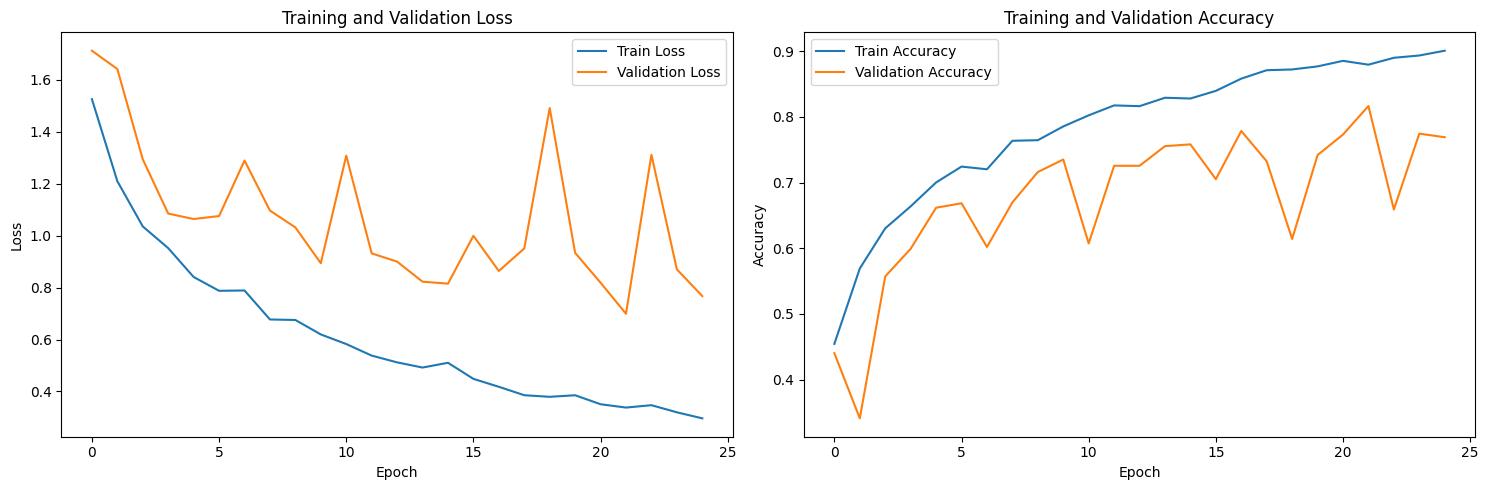

Evaluating on test set...
Classification Report:
                precision    recall  f1-score   support

           Red       0.94      0.88      0.91       273
         White       0.92      0.80      0.86       178
          Rose       0.91      0.79      0.84        61
     Specialty       0.26      0.43      0.32        21
     Sparkling       0.65      0.72      0.68        81
Sake_Rice_wine       0.73      0.90      0.81        51
       Icewine       0.71      0.71      0.71         7
     Fortified       0.67      0.72      0.69        25
       Dessert       0.26      0.50      0.34        16
     Champagne       0.57      0.50      0.53        24

      accuracy                           0.80       737
     macro avg       0.66      0.70      0.67       737
  weighted avg       0.83      0.80      0.81       737



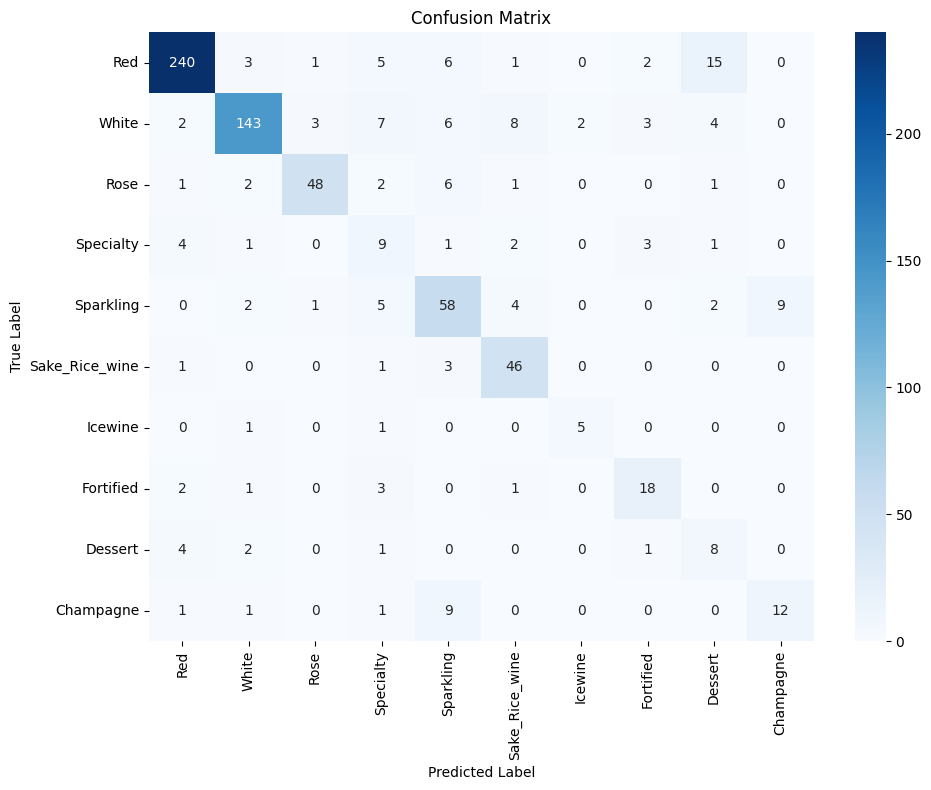

Training completed! Model saved as 'wine_classifier_final.pth'


In [ ]:
def main():
    DATA_PATH = '/content/drive/MyDrive/Wine_Data/Data'
    XLSX_FILE = '/content/drive/MyDrive/Wine_Data/wine_data_1.xlsx'  
    MODEL_NAME = "resnet50"
    NUM_EPOCHS = 25
    BATCH_SIZE = 32

    print("Preparing data...")
    train_loader, val_loader, test_loader, class_names = prepare_data(
        DATA_PATH, XLSX_FILE, BATCH_SIZE
    )

    print(f"Classes: {class_names}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    print(f"Test samples: {len(test_loader.dataset)}")

    print("Creating model...")
    model = create_model(MODEL_NAME, len(class_names), fine_tune=True)

    print("Starting training...")
    history = train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS)

    # Plot training history
    plot_training_history(history)

    # Load best model for evaluation
    model.load_state_dict(torch.load('best_model.pth'))

    # Evaluate on test set
    print("Evaluating on test set...")
    evaluate_model(model, test_loader, class_names)

    # Save final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': class_names,
        'model_arch': MODEL_NAME
    }, 'wine_classifier_final.pth')

    print("Training completed! Model saved as 'wine_classifier_final.pth'")


main()